In [1]:
# Janky xgboost fix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import numpy as np
import re
import os.path
import xgboost as xgb
import imblearn.over_sampling
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

### Load Data

In [2]:
order_path = '../data/subset/'
common_path = '../data/common/'

In [18]:
orders_df = pd.read_csv(os.path.join(order_path, 'orders.csv'))
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [19]:
orders_prior_df = pd.read_csv(os.path.join(order_path, 'order_products__prior.csv'))
orders_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [20]:
orders_train_df = pd.read_csv(os.path.join(order_path, 'order_products__train.csv'))
orders_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [6]:
depts_df = pd.read_csv(os.path.join(common_path, 'departments.csv'))
depts_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
aisles_df = pd.read_csv(os.path.join(common_path, 'aisles.csv'))
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [12]:
products_df = pd.read_csv(os.path.join(common_path, 'products.csv'))
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Merge Product Dataframes

In [13]:
products_df = products_df.merge(aisles_df, how='left', on='aisle_id')
products_df = products_df.merge(depts_df, how='left', on='department_id')
products_df.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products_df.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [21]:
orders_prior_df = orders_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df = orders_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,22,6,8,10.0
1,12,15221,2,1,152610,22,6,8,10.0
2,12,43772,3,1,152610,22,6,8,10.0
3,12,37886,4,1,152610,22,6,8,10.0
4,12,37215,5,0,152610,22,6,8,10.0


### Feature: Product Overall Order Rate

In [46]:
product_prior_df = (orders_prior_df.groupby(['product_id'], as_index=False)
                                   .agg({'order_id':'nunique'})
                                   .rename(columns={'order_id':'count_in_all_orders'})
                                   .sort_values(by=['count_in_all_orders'], ascending=False)
                                   .reset_index(drop=True))
num_orders = orders_prior_df['order_id'].nunique()
product_prior_df['percent_in_all_orders'] = product_prior_df['count_in_all_orders'] / num_orders
product_prior_df.head(10)

,product_id,count_in_all_orders,percent_in_all_orders
0,24852,10951,0.140970
1,13176,9424,0.121314
2,21903,6028,0.077597
3,21137,6020,0.077494
4,47209,5108,0.065754
5,47766,4337,0.055829
6,47626,3659,0.047102
7,16797,3449,0.044398
8,27966,3391,0.043652
9,26209,3329,0.042854


### Merge Cart-level DataFrame

In [79]:
user_product_prior_df = (orders_prior_df.groupby(['product_id', 'user_id'], as_index=False)
                                        .agg({'order_id':'nunique', 'add_to_cart_order':'mean'})
                                        .rename(columns={'order_id':'count_in_user_orders',
                                                         'add_to_cart_order':'mean_cart_add_order'}))

train_users = orders_train_df['user_id'].unique()
user_product_df = user_product_prior_df[user_product_prior_df['user_id'].isin(train_users)]
user_product_df.reset_index(drop=True, inplace=True)

orders_prior_per_user_df = orders_prior_df.groupby(['user_id'])[['order_id']].nunique()
orders_prior_per_user_df.rename(columns={'order_id':'total_user_orders'}, inplace=True)
user_product_df = user_product_prior_df.merge(orders_prior_per_user_df, on='user_id')
user_product_df['percent_in_user_orders'] = (user_product_df['count_in_user_orders'] /
                                             user_product_df['total_user_orders'])
user_product_df.head()

,product_id,user_id,count_in_user_orders,mean_cart_add_order,total_user_orders,percent_in_user_orders
0,1,21285,1,3.0,48,0.020833
1,3298,21285,1,5.0,48,0.020833
2,4920,21285,3,5.0,48,0.062500
3,6066,21285,2,5.5,48,0.041667
4,6184,21285,6,7.5,48,0.125000


In [80]:
train_carts = (orders_train_df.groupby('user_id')
                              .agg({'product_id':(lambda x: set(x))})
                              .rename(columns={'product_id':'cart_contents'}))

user_product_df = user_product_df.merge(train_carts, on='user_id')
user_product_df['in_cart'] =\
    (user_product_df.apply(lambda row: row['product_id'] in row['cart_contents'], axis=1)
                    .astype(int))
user_product_df = user_product_df.merge(product_prior_df.drop(['count_in_all_orders'], axis=1),
                                        on='product_id')

user_product_df.head()

,product_id,user_id,count_in_user_orders,mean_cart_add_order,total_user_orders,percent_in_user_orders,cart_contents,in_cart,percent_in_all_orders
0,1,21285,1,3.0,48,0.020833,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,0.000335
1,1,47549,4,4.0,26,0.153846,"{27845, 27790, 13042, 10326, 37687}",0,0.000335
2,1,54136,1,3.0,23,0.043478,"{47977, 5450, 26604, 5296, 11123, 24852, 10070...",0,0.000335
3,1,54240,1,2.0,5,0.200000,"{12427, 26348}",0,0.000335
4,1,95730,1,1.0,9,0.111111,"{39657, 10441, 12427, 37710, 10258, 32921, 45051}",0,0.000335


### Split Into Train, Validate, and Test Sets

In [129]:
def train_val_test_by_user(df, x_cols, y_col, val_size=.2, test_size=.1, seed=29):
    rndm = np.random.RandomState(seed)
    all_users = df['user_id'].unique()
    
    # Splits off holdout test set
    non_test_users = rndm.choice(all_users,
                                 size=int(all_users.size * (1-test_size)),
                                 replace=False)
    test_df = df[~df['user_id'].isin(non_test_users)]
    
    # Splits off train and validation sets
    val_users = rndm.choice(non_test_users,
                            size=int(all_users.size * val_size),
                            replace=False)
    val_df = df[df['user_id'].isin(val_users)]
    train_df = df[~df['user_id'].isin(val_users)]
    
    return (train_df[x_cols], train_df[y_col],
            val_df[x_cols], val_df[y_col],
            test_df[x_cols], test_df[y_col])

In [381]:
x_cols = ['percent_in_user_orders',
          'percent_in_all_orders',
          'mean_cart_add_order']
y_col = 'in_cart'

X_train, y_train, X_val, y_val, X_test, y_test =\
    train_val_test_by_user(user_product_df, x_cols, y_col)

In [382]:
y_train.size, y_val.size, y_test.size

(265601, 64205, 34097)

### EDA

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


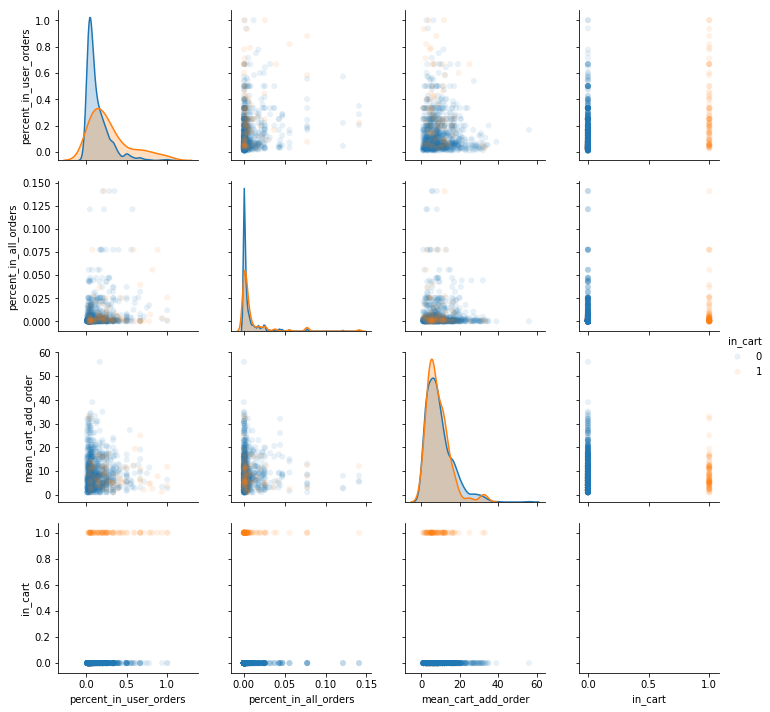

In [383]:
eda_df = pd.concat([X_train, y_train], axis=1).sample(1000)
sns.pairplot(eda_df, hue='in_cart', plot_kws=dict(alpha=.1, edgecolor='none'));

### Oversampling (Inactive)
Only significantly improved Logistic Regression
* Logistic = .23 to .35
* KNN = .24 to .29
* Random Forest = .24 to .27
* xgboost = .29 to .32

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_neg, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(ratio=ratio, random_state=29)    
X_train, y_train = ROS.fit_sample(X_train, y_train)

### Generic Threshold Adjustment Function

In [303]:
def adjust_threshold(model, X, threshold=.5):
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

### Baseline Logistic Regression

In [175]:
def optimize_logistic_c(X_train, y_train, X_val, y_val):
    max_c = max_score = max_model = 0
    for c in range(-3, 6):
        c_val = 10 ** c
        model = LogisticRegression(C=c_val, solver='lbfgs', multi_class='auto')
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_c = c_val
            max_score = score
            max_model = model
            
    print(f'C = {max_c} yields the highest score: {max_score}')
    return max_model

In [384]:
lr = optimize_logistic_c(X_train, y_train, X_val, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C = 10 yields the highest score: 0.22714338735617962


In [385]:
y_pred = lr.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.22714338735617962, 0.5773584905660377, 0.14138302787617435)

In [386]:
y_adj = adjust_threshold(lr, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.38169777242624925, 0.3732155997056659, 0.39057446480825503)

### Baseline KNN Classifier

In [184]:
def optimize_knn(X_train, y_train, X_val, y_val, max_iter=20):
    max_k = max_score = max_model = 0
    for k in range(1, max_iter+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_k = k
            max_score = score
            max_model = model
            
    print(f'k = {max_k} yields the highest score: {max_score}')
    return max_model

In [387]:
knn = optimize_knn(X_train, y_train, X_val, y_val)

k = 3 yields the highest score: 0.23431904225928576


In [388]:
y_pred = knn.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.23431904225928576, 0.3490853658536585, 0.1763437548128754)

In [389]:
y_adj = adjust_threshold(knn, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.2786372007366482, 0.19872594733039994, 0.4660403511473895)

### Baseline Random Forest Classifier

In [390]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X_train, y_train);

In [391]:
y_pred = rf.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.21550290939318376, 0.3312040881507506, 0.15971045741567844)

In [392]:
y_adj = adjust_threshold(rf, X_val, .2)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.3023358741086796, 0.22207773443144055, 0.47343292776836593)

### Baseline xgboost

In [393]:
gbm = xgb.XGBClassifier(n_estimators=30000,
                        max_depth=5,
                        objective="binary:logistic",
                        learning_rate=1, 
                        subsample=.009,
                        min_child_weight=1,
                        colsample_bytree=.8)

fit_model = gbm.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_val, y_val)],
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False);

In [394]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.276181250672694, 0.45854181558255896, 0.19759741259818267)

In [395]:
y_adj = adjust_threshold(gbm, X_val, .27)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.3251458145075166, 0.3484154929577465, 0.304789773602341)

### Group Common Products
* Brand name is often at the beginning
* Product name is often at the end
* Could look for words in common among products

### Merge Order and User Info

In [27]:
order_prods_df = order_prods_df.merge(products_df, how='left', on='product_id')
order_prods_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,1077,13176,1,1,Bag of Organic Bananas,produce,fresh fruits
1,1077,39922,2,1,Celery Sticks,produce,packaged vegetables fruits
2,1077,5258,3,1,Sparkling Water,beverages,water seltzer sparkling water
3,1077,21137,4,1,Organic Strawberries,produce,fresh fruits
4,1119,6046,1,1,Boneless Skinless Chicken Breast,meat seafood,poultry counter
